# Analysis of our data

1. Data collecting and data cleaning 
2. Computations for the creation of the adjacency matrix and the graph
3. Graph creation
4. Analysis

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas.io.json import json_normalize
import pickle
import re
import scipy as sp
from scipy import stats
from scipy import sparse
import scipy.sparse.linalg
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import nltk
import omdb
import networkx as nx
from termcolor import colored

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None

In [2]:
%matplotlib inline

# 1. Data collecting and data cleaning

In [3]:
#import dataset
FILE_PATH_CREW = "../Data/tmdb_5000_credits.csv"

features_crew = pd.read_csv(FILE_PATH_CREW)

# Dataframe with info about the movies
features_crew.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
#specify your API_KEY used to set client
API_y_KEY = '3a7e30ce'
omdb.set_default('apikey', API_y_KEY)
client = omdb.OMDBClient(apikey=API_y_KEY)

In [ ]:
#We have a 1000 request limit so you can decide here at which film you want to start and where to end 
id_end = 4803
id_start = id_end - 1000

In [ ]:
#creates empty dictionary then updates it using the movie_id as a key and the output of the
#request as value (note that that res.content isn't actually a dict but a byte object, we may
#need to convert it later)

collected = dict()

for i in range(id_start, id_end):
    title = features_crew.title[i]
    res = omdb.request(t=title, tomatoes=True)
    movie_json = res.content
    collected[str(features_crew.movie_id[i])] = movie_json

In [ ]:
# saves collected as pickle
with open('metacrit.p', 'wb') as fp:
    pickle.dump(collected, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
# loads collected
with open('metacrit.p', 'rb') as fp:
    test_data = pickle.load(fp)

# 2. Computations for the creation of the adjacency matrix and the graph

In [43]:
df = pd.DataFrame.from_dict(test_data, orient='index')
df.head()

,0
19995,"b'{""Title"":""Avatar"",""Year"":""2009"",""Rated"":""PG-..."
285,"b'{""Title"":""Pirates of the Caribbean: At World..."
206647,"b'{""Title"":""Spectre"",""Year"":""2015"",""Rated"":""PG..."
49026,"b'{""Title"":""The Dark Knight Rises"",""Year"":""201..."
49529,"b'{""Title"":""John Carter"",""Year"":""2012"",""Rated""..."


In [44]:
dataframe = pd.read_json(df.iloc[0].values[0])

for i in range(1, len(df)):
    if len(df.iloc[i].values[0]) > 100:
        movie = pd.read_json(df.iloc[i].values[0])
    dataframe = pd.concat([dataframe, movie])

In [45]:
# We decided to drop the useless columns that did not contain information about the movie
# These columns are: - urls (Poster, Website, tomatoImage)
#                    - columns related to the API (Response, Type)
#                    - columns where all entries are NaN
#                    - Irrelevant columns (DVD, ie release date of dvd, Runtime, Released, Year, Country, Language, 
#                                          imdbVotes)
#                    - Redundant columns (imdbID is redundant with Title)

dataframe = dataframe.drop(columns=['Poster', 'Response', 'Type', 'Website', 'tomatoConsensus', 
                                    'tomatoFresh', 'tomatoImage', 'tomatoMeter', 'tomatoRating', 
                                    'tomatoReviews', 'tomatoRotten', 'tomatoURL', 'tomatoUserMeter', 
                                    'tomatoUserRating', 'tomatoUserReviews', 'totalSeasons', 'DVD', 
                                    'Year', 'imdbID', 'Runtime', 'Released', 'Country', 'Language', 'imdbVotes'])
dataframe.head()

,Actors,Awards,BoxOffice,Director,Genre,Metascore,Plot,Production,Rated,Ratings,Title,Writer,imdbRating
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000",James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",Avatar,James Cameron,7.8
1,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000",James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '82%'}",Avatar,James Cameron,7.8
2,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000",James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Metacritic', 'Value': '83/100'}",Avatar,James Cameron,7.8
0,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,"$309,404,152",Gore Verbinski,"Action, Adventure, Fantasy",50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",7.1
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,"$309,404,152",Gore Verbinski,"Action, Adventure, Fantasy",50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '44%'}",Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",7.1


We now need to transform the types so that it is easier to analyze the features. As of now, almost all the entries of our dataframe are strings. We have a few entries that are integer numbers that need to be converted: BoxOffice and Metascore.

Metascore is already in an appropriate format, we just need to cast the type. However, BoxOffice needs a little bit of tinkering.

In [46]:
# For BoxOffice we need to remove the $ and commas
dataframe['BoxOffice'] = dataframe['BoxOffice'].apply(lambda x: x.replace("$", ""))
dataframe['BoxOffice'] = dataframe['BoxOffice'].apply(lambda x: x.replace(",", ""))
dataframe['BoxOffice'] = dataframe['BoxOffice'].replace('N/A', np.nan)
dataframe['BoxOffice'] = dataframe['BoxOffice'].astype(float)
dataframe = dataframe.dropna()
dataframe['BoxOffice'] = dataframe['BoxOffice'].astype(int)
# Metascore
dataframe['Metascore'] = dataframe['Metascore'].replace('N/A', np.nan)
dataframe = dataframe.dropna()
dataframe['Metascore'] = dataframe['Metascore'].astype(int)

In [47]:
dataframe.head()

,Actors,Awards,BoxOffice,Director,Genre,Metascore,Plot,Production,Rated,Ratings,Title,Writer,imdbRating
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",Avatar,James Cameron,7.8
1,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '82%'}",Avatar,James Cameron,7.8
2,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Metacritic', 'Value': '83/100'}",Avatar,James Cameron,7.8
0,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,Gore Verbinski,"Action, Adventure, Fantasy",50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",7.1
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,Gore Verbinski,"Action, Adventure, Fantasy",50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '44%'}",Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",7.1


Now, we need to regroup the different sources of ratings so that the movies are not repeated three times in the dataframe.

- The first rating comes from imdb. It is already present in the dataframe under the name imdbRating
- The second rating comes from Rotten Tomatoes. It is not present in the dataframe yet, we need to retrieve it from Ratings
- The third rating comes from Metacritic. It is already present in the dataframe under the name Metascore.

The only rating we need to keep from Ratigs is the grade from Rotten Tomatoes. We will hence remove all the rows containing ratings only from imdb or metacritics and then rename the Ratings column. 

We wish to separate this column into 3 columns, drop the duplicate rows and convert the ratings to percentages for a more uniform notation.

In [48]:
dataframe_ = dataframe.copy()

In [49]:
def transform_tomatograde(strgrade):
    if '/10' in strgrade:
        grade = strgrade.replace('/10', '').replace('.', '')
    elif '%' in strgrade:
        grade = strgrade.replace('%', '')
    elif '/100' in dataframe_['metacriticGrade'][i]:
        grade = strgrade.replace('/100', '')
    else:
        grade = float(dataframe_['tomatoGrade'][i])
        if grade > 100:
            grade = grade / 10
    
    return int(grade)   

In [50]:
# 1. Extract the Rotten Tomatoes grade
dataframe_['RatingIndex'] = dataframe_.index
dataframe_ = dataframe_.reset_index(drop=True)
dataframe_['tomatoGrade'] = np.nan
for i in range(len(dataframe_[dataframe_.RatingIndex == 1])):
    title = dataframe_[dataframe_.RatingIndex == 1].iloc[i].Title
    idx = dataframe_[dataframe_.Title == title].index[0]
    grade = transform_tomatograde(dataframe_[dataframe_.RatingIndex == 1].iloc[i].Ratings['Value'])
    dataframe_.at[idx, 'tomatoGrade'] = grade
dataframe_ = dataframe_[dataframe_.RatingIndex == 0]
dataframe_ = dataframe_.drop(columns=['RatingIndex'])

# 2. Rename the Metacritics and imdb grades
dataframe_ = dataframe_.rename(columns={'imdbRating' : 'imdbGrade', 'Metascore' : 'metacriticGrade'})

# 3. Drop NaN
dataframe_ = dataframe_.dropna()

# 4. Transform grades
dataframe_['imdbGrade'] = dataframe_['imdbGrade']*10
dataframe_['imdbGrade'] = dataframe_['imdbGrade'].astype(int)
dataframe_['tomatoGrade'] = dataframe_['tomatoGrade'].astype(int)
dataframe_['metacriticGrade'] = dataframe_['metacriticGrade'].astype(int)

# 5. Reset index
dataframe_ = dataframe_.reset_index(drop=True)

# 6. Drop the Ratings column
dataframe_ = dataframe_.drop(columns=['Ratings'])

In [51]:
dataframe_.head()

,Actors,Awards,BoxOffice,Director,Genre,metacriticGrade,Plot,Production,Rated,Title,Writer,imdbGrade,tomatoGrade
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,Avatar,James Cameron,78,82
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,Gore Verbinski,"Action, Adventure, Fantasy",50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",71,44
2,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra...",Won 1 Oscar. Another 7 wins & 32 nominations.,208777731,Sam Mendes,"Action, Adventure, Thriller",60,A cryptic message from 007's past sends him pi...,Sony Pictures,PG-13,Spectre,"John Logan (screenplay by), Neal Purvis (scree...",68,64
3,"Christian Bale, Gary Oldman, Tom Hardy, Joseph...",Nominated for 1 BAFTA Film Award. Another 38 w...,448130642,Christopher Nolan,"Action, Thriller",78,Eight years after the Joker's reign of anarchy...,Warner Bros. Pictures,PG-13,The Dark Knight Rises,"Jonathan Nolan (screenplay), Christopher Nolan...",84,87
4,"Taylor Kitsch, Lynn Collins, Samantha Morton, ...",2 wins & 8 nominations.,73058679,Andrew Stanton,"Action, Adventure, Sci-Fi",51,"Transported to Barsoom, a Civil War vet discov...",Walt Disney Pictures,PG-13,John Carter,"Andrew Stanton (screenplay by), Mark Andrews (...",66,51


Now, we need to deal with the string attributes that are in form of a list. We want a set of strings, each string corresponding to an individual characteristic (director, actor, etc).

In order to do so, we split the string at the commas. For the Writer attribute, we decided to remove the specifications and only keep the names of the writers, taking off who wrote the story, screenplay or characters.

In [52]:
dataframe_['Actors'] = dataframe_['Actors'].apply(lambda x: set(x.split(', ')))
dataframe_['Director'] = dataframe_['Director'].apply(lambda x: set(x.split(', ')))
dataframe_['Genre'] = dataframe_['Genre'].apply(lambda x: set(x.split(', ')))
dataframe_['Writer'] = dataframe_['Writer'].apply(lambda x: re.sub(" [\(\[].*?[\)\]]", "", x))
dataframe_['Writer'] = dataframe_['Writer'].apply(lambda x: set(x.split(', ')))

Now, we deal with the Production company. We have observed that a same company has different names within this dataset, sometimes the names diferring only by a space or an add-on (like "distribution"). We want to uniformize this. First, we remove all the words such as "Company" or "Industries" so that all production companies have only their core name. 

In [53]:
to_remove = [' Corporation', ' Distribution', ' Corporat', ' Production', ' Films', ' Film', 
             ' Pictures', ' Picutres', ' Internationa', ' International', ' Industries', ' Compa', 
             ' Co', ' Distribu', ' Studios', ' Animation', ' Feature', ' SKG', ' LLC', ' Recommends', 
             ' Digital', ' Media', ' Video', ' Inc', ' Home Entertainment', ' Entertainment', ' Lorber', 
             ' Releasing', ' Cinema.', ' Cinema', ' Classics', ' Classic', ' Group', ' Europacorp', 
             ' Pvt. Ltd.', ' Ventures', ' [us]', ' Pictur', ' Home', ' Focus', ' City', ' Atomic', 
             ' Faith', ' Searchlight', ' Walden', '.', ' TriStarl', ' TriStar', ' Tristar']
for word in to_remove:
    dataframe_['Production'] = dataframe_['Production'].str.replace(word, '')

Next, we replace all misspelled or differently spelled company names by one spelling. 

In [54]:
dataframe_['Production'] = dataframe_['Production'].str.replace('-', ' ')
dataframe_['Production'] = dataframe_['Production'].str.replace(' / ', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace(' /', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace('/ ', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace('DreamWorks', 'Dreamworks')
dataframe_['Production'] = dataframe_['Production'].str.replace('Dream Works', 'Dreamworks')
dataframe_['Production'] = dataframe_['Production'].str.replace("Lion's Gate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("Liongate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("Lions Gate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("LionsGate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace('Metro Goldwyn Mayer (MGM)', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace('Metro Goldwyn Mayer', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace('WARNER BROTHERS PICTURES', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('WB', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Weinsteinny', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Brothers', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Home', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Independent', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('PIXAR', 'Pixar')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warners Bros', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Universall', 'Universal')
dataframe_['Production'] = dataframe_['Production'].str.replace('The Weinstein', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Vantage', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace('/lumbia', '/ Columbia')
dataframe_['Production'] = dataframe_['Production'].str.replace('MGM (MGM)', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace(' First Take', '/ Columbia')
dataframe_['Production'] = dataframe_['Production'].str.replace('Goodbye Cruel', 'Goodbye Cruel World')
dataframe_['Production'] = dataframe_['Production'].str.replace('FoxFaith', 'Fox')
dataframe_['Production'] = dataframe_['Production'].str.replace('Fine Line', 'Fine Lines')
dataframe_['Production'] = dataframe_['Production'].str.replace('Erosl', 'Eros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Walt Disneys', 'Disney')
dataframe_['Production'] = dataframe_['Production'].str.replace('Walt Disney', 'Disney')

In [55]:
dataframe_['Production'] = dataframe_['Production'].apply(lambda x: set(x.split('/')))

Now, we deal with the plot. For this NLP task, we will keep it simple. We only kept the common nouns (singular or plural).

In [56]:
def find_nouns(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNS')]
    return set(nouns)

In [57]:
dataframe_['Plot'] = dataframe_['Plot'].apply(lambda x: find_nouns(x))

We need to format the Awards feature. The current Awards column contains a string (sentence) describing how many awards the movie has won or has been nominated to. It also specifies if it has won or been nominated to Oscars or BAFTA. We believe that when it is specified, the higher "award" is listed, i.e. if the movie won 2 Oscars, the 5 Oscar nominations won't be specified. The most useful format we could think of is to transform this award column into 2 distinct columns, since we cannot infer how many nominations to the Oscars a movie has when it has already won some. The columns are hence: 

- Wins
- Nominations

In [58]:
def find_wins_nominations(string):
    wins = 0
    noms = 0
    
    splitted = string.split('. ')
    if len(splitted) > 1:
        string1 = splitted[0]
        if re.search('nominated', string1, re.IGNORECASE):
            noms = noms + int(string1.split(' ')[2])
        if re.search('won', string1, re.IGNORECASE):
            wins = noms + int(string1.split(' ')[1])
        
        string2 = splitted[1]
        if re.search('nomination', string2, re.IGNORECASE):
            noms = noms + int(string2.split(' nomination')[0].split(' ')[-1])
        if re.search('win', string2, re.IGNORECASE):
            wins = wins + int(string2.split(' win')[0].split(' ')[-1])
    elif len(splitted) == 1:
        split_string = splitted[0]
        if re.search('nomination', split_string, re.IGNORECASE):
            noms = noms + int(split_string.split(' nomination')[0].split(' ')[-1])
        if re.search('win', split_string, re.IGNORECASE):
            wins = wins + int(split_string.split(' win')[0].split(' ')[-1])
    return wins, noms

In [59]:
dataframe_['Wins'] = 0
dataframe_['Nominations'] = 0

for i in range(0, len(dataframe_)):
    wins, noms = find_wins_nominations(dataframe_.Awards[i])
    dataframe_['Wins'][i] = wins
    dataframe_['Nominations'][i] = noms
dataframe_ = dataframe_.drop(columns='Awards')

The Rated attribute is not uniform and has multiple conventions. We seek to normalize it. We decided to use the Motion Picture Association of America film rating system, which states that:

- **G: General Audiences. All ages admitted.** Nothing that would offend parents for viewing by children.
- **PG: Parental Guidance Suggested.** Some material may not be suitable for children. Parents urged to give "parental guidance". May contain some material parents might not like for their young children.
- **PG-13: Parents Strongly Cautioned.** Some material may be inappropriate for children under 13. Parents are urged to be cautious. Some material may be inappropriate for pre-teenagers.
- **R: Restricted. Under 17 requires accompanying parent or adult guardian.** Contains some adult material. Parents are urged to learn more about the film before taking their young children with them.
- **NC-17: Adults Only.** No One 17 and Under Admitted. Clearly adult. Children are not admitted.

https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system

**X** rating means persons under 16 not admitted. For our analysis, we decided to conflate that label within **NC-17**

Following this, we need to make some modifications: 

- Approved -> G
- GP -> PG
- M -> R
- Passed -> G
- TV-14 -> PG-13
- TV-G -> G
- TV-MA -> R
- TV-PG -> PG
- X -> NC-17
- Unrated, Not rated and N/A make up their own category **Unrated**

In [60]:
# Replacing all differently rated categories by the standard ones
dataframe_['Rated'] = dataframe_['Rated'].str.replace('APPROVED', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('GP', 'PG')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('M', 'R')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('PASSED', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-14', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('APPROVED', 'PG-13')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-G', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-MA', 'R')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-PG', 'PG')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('X', 'NC-17')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('NOT RATED', 'UNRATED')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('N/A', 'UNRATED')

In [61]:
dataframe_['Rated'] = dataframe_['Rated'].apply(lambda x: {x})

In [62]:
dataframe_.to_pickle("df.pkl")

In [63]:
dataframe_ = pd.read_pickle("df.pkl")

Finally, we need to add the budget. For that, we use the budget column in the Kaggle imdb dataset.

In [64]:
FILE_PATH_MOVIE = "../Data/tmdb_5000_movies.csv"
movie_df = pd.read_csv(FILE_PATH_MOVIE)

budget_df = movie_df[['budget', 'title']]
budget_df = budget_df.rename(columns={"budget" : "Budget", "title" : "Title"})

final_df = dataframe_.merge(budget_df, how='inner')

In [65]:
# Budget is weirdly formatted: there are movies that state a single number budget to signify its millions.
# Let's unify it

final_df['Budget'].iloc[1971] = final_df['Budget'].iloc[1971] * 10**6
final_df['Budget'].iloc[1608] = final_df['Budget'].iloc[1608] * 10**6
final_df['Budget'].iloc[2330] = final_df['Budget'].iloc[2330] * 10**6
final_df['Budget'].iloc[1861] = 5500000
final_df['Budget'].iloc[2310] = 650000
final_df['Budget'].iloc[764] = 45000000
final_df['Budget'].iloc[2349] = 153000

# Moreover, we have budgets that are 0. We will replace these as np.nan then drop the whole row
final_df['Budget'] = final_df['Budget'].apply(lambda x: np.nan if x==0 else x)

In [66]:
final_df = final_df.dropna()

Now, Budget is a continuous variable. We decided to create categories so as to sparsify the network. We did this by looking at the histogram and by taking into account the usual budget categories: 

- No budget: less than 100 000 \$
- Independent: 100 000 to 10 million \$
- Low: 10 to 40 million \$
- Medium: 41 to 100 million \$
- High: 101 million and up \$

Since these are ordinal categories, each will be coded with an integer (ranging from 1 to 5). 

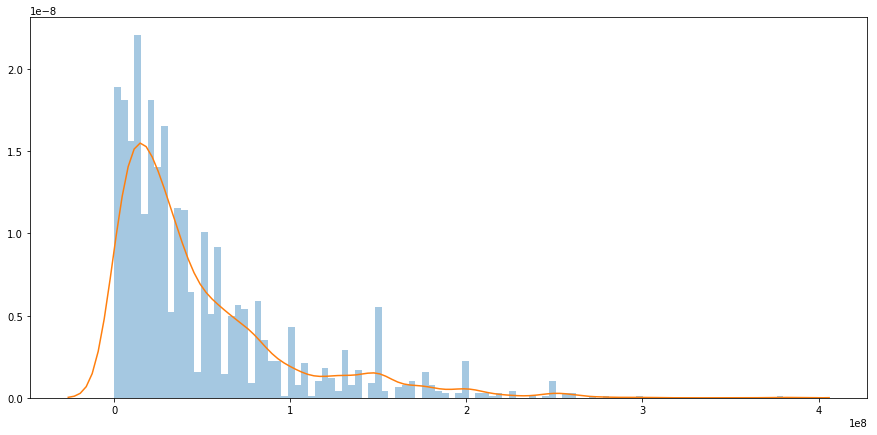

In [67]:
plt.figure(figsize=(15,7))
sns.distplot(final_df['Budget'].dropna().values, kde=False, norm_hist=True, bins=100)
sns.kdeplot(final_df['Budget'].dropna().values, kernel='gau')
plt.show()

In [68]:
# No budget: less than 100 000 
# Independent: 100 000 to 10 million 
# Low: 10 to 40 million 
# Medium: 41 to 100 million 
# High: 101 million and up 

def transform_budget(budget):
    if budget < 100000:
        budget_cat = 1
    elif budget >= 100000 and budget < 10000000:
        budget_cat = 2
    elif budget >= 10000000 and budget < 40000000:
        budget_cat = 3
    elif budget >= 40000000 and budget < 100000000:
        budget_cat = 4
    elif budget >= 100000000:
        budget_cat = 5
        
    return budget_cat

In [69]:
final_df.Budget = final_df.Budget.apply(lambda x: transform_budget(x))

In [70]:
final_df = final_df.dropna()
final_df = final_df.reset_index(drop=True)

In [71]:
final_df.to_pickle("final_df.pkl")

### Data cleaning results

We get a dataframe with the following features:

- Actors, Director, Writer
- Genre
- Budget
- Production
- Plot
- Country, Language
- Release date
- Runtime
- Rated category (PG-13, 18...)

Each movie has one identifyier:

- Title

And we have several labels that define the success of the movie:

- Box Office
- imdb Grade (+ imdb votes)
- Rotten Tomatoes Grade
- Metacritic Grade
- Wins and Nominations

# 3. Correlations

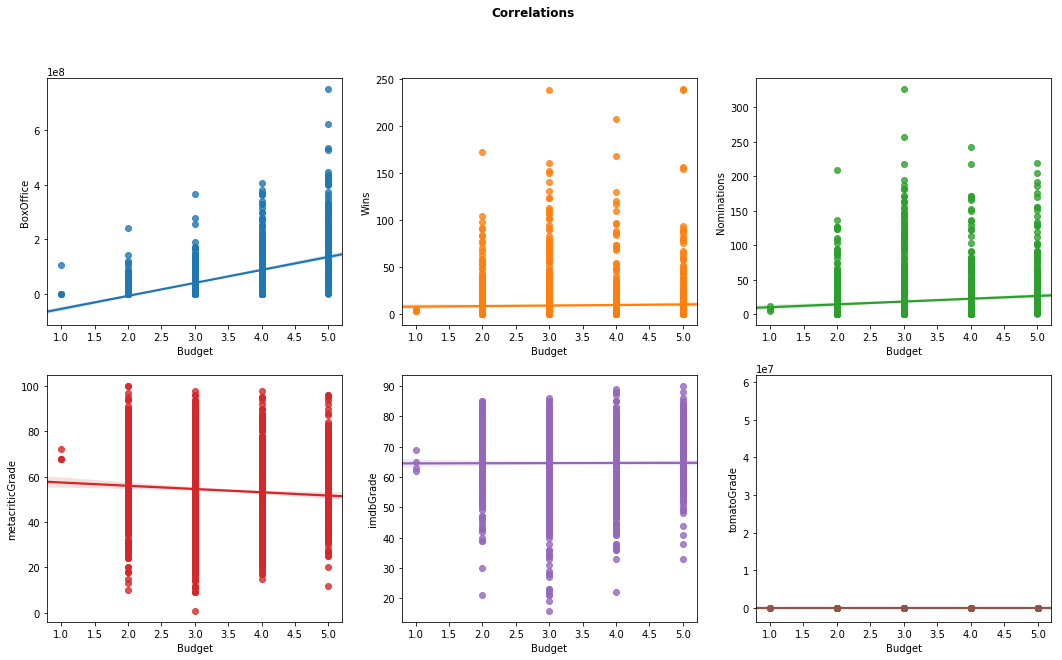

In [234]:
# Numerical features: Budget
# Numerical labels: 'BoxOffice', 'metacriticGrade', 'imdbGrade', 'tomatoGrade', 'Wins', 'Nominations'
# => 6 correlations to compute

fig, (axs) = plt.subplots(2, 3, figsize=(18, 10))
sns.regplot(x=final_df['Budget'], y=final_df['BoxOffice'], ax=axs[0,0])
sns.regplot(x=final_df['Budget'], y=final_df['Wins'], ax=axs[0,1])
sns.regplot(x=final_df['Budget'], y=final_df['Nominations'], ax=axs[0,2])
sns.regplot(x=final_df['Budget'], y=final_df['metacriticGrade'], ax=axs[1,0])
sns.regplot(x=final_df['Budget'], y=final_df['imdbGrade'], ax=axs[1,1])
sns.regplot(x=final_df['Budget'], y=final_df['tomatoGrade'], ax=axs[1,2])

fig.suptitle("""Correlations""", fontweight="bold")
#plt.xlabel("Median revenue (€)")
#plt.ylabel("Energy per 100g of product (kcal)")
plt.show()

In [278]:
def pearson_pval_df(df):
    """Compute and display the Pearson coefficient and the p-value between the Budget
    and each label
    
    A line displayed in red means that the correlation is not significant.
    A line displayed in green means that the  correlation is significant.
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the values for each feature and label.
    """
    print('Linear correlation between Budget and each of the label columns')
    label_cols = ['BoxOffice', 'metacriticGrade', 'imdbGrade', 'tomatoGrade', 'Wins', 'Nominations']
    for col in label_cols:
        r, p = stats.pearsonr(df[col], df['Budget'])
        if p < 0.05:
            color = 'green'
        else:
            color = 'red'
        print(colored('{:<40}{:<16}{:<28.3f}{:<10}{:<30.3f}'.format(col, 'Pearson coeff', r, 'p-value', p), color))

    print('\n')

In [279]:
pearson_pval_df(final_df)

Linear correlation between Budget and each of the label columns
BoxOffice                               Pearson coeff   0.579                       p-value   0.000                         
metacriticGrade                         Pearson coeff   -0.074                      p-value   0.001                         
imdbGrade                               Pearson coeff   0.004                       p-value   0.864                         
tomatoGrade                             Pearson coeff   -0.098                      p-value   0.000                         
Wins                                    Pearson coeff   0.024                       p-value   0.288                         
Nominations                             Pearson coeff   0.113                       p-value   0.000                         




Positive and very significant correlation between Budget and BoxOffice (unsurprising). 

There is a significant lack of relationship between the budget and the metacritic / rotten tomatoes grades. 

There is a significant positive relationship between the budget and the nominations. We cannot call it a correlation since the Pearson coefficient for this relationship is still low. Moreover, by looking at the graph we can see that the relationship is actually not a correlation.

# 4. Graph creation

After data cleaning, we proceed to the creation of the graph by computing its adjacency matrix. We wish to create an adjacency matrix containing all features. We will hence compute several adjacency matrices that we will then add (using weighting factors). Such matrices are:

- Crew (actors, writers and directors): how many crew members the movies have in common
- Budget: the similarity between movies will be based on how close the budgets are (in a log scale)
- Genre: how many genres two movies have in common
- Production: is it the same production company?
- Plot: how many common words two films have in common
- Rated category: binary score = same category or different

In [3]:
final_df = pd.read_pickle("final_df.pkl")
final_df.head()

,Actors,BoxOffice,Director,Genre,metacriticGrade,Plot,Production,Rated,Title,Writer,imdbGrade,tomatoGrade,Wins,Nominations,Budget
0,"{Sam Worthington, Sigourney Weaver, Zoe Saldan...",749700000,{James Cameron},"{Adventure, Sci-Fi, Fantasy, Action}",83,"{marine, mission, world, moon, home, orders}",{20th Century Fox},{PG-13},Avatar,{James Cameron},78,82,88,128,5
1,"{Geoffrey Rush, Orlando Bloom, Keira Knightley...",309404152,{Gore Verbinski},"{Adventure, Fantasy, Action}",50,"{treachery, map, battle, betrayal, edge, allia...",{Buena Vista},{PG-13},Pirates of the Caribbean: At World's End,"{Jay Wolpert, Ted Elliott, Terry Rossio, Stuar...",71,44,20,46,5
2,"{Daniel Craig, Léa Seydoux, Christoph Waltz, R...",208777731,{Sam Mendes},"{Thriller, Adventure, Action}",60,"{message, missions, events, learns, organizati...",{Sony},{PG-13},Spectre,"{Ian Fleming, Neal Purvis, Jez Butterworth, Ro...",68,64,8,32,5
3,"{Gary Oldman, Tom Hardy, Joseph Gordon-Levitt,...",448130642,{Christopher Nolan},"{Thriller, Action}",78,"{help, reign, anarchy, exile, guerrilla, edge,...",{Warner Bros},{PG-13},The Dark Knight Rises,"{Christopher Nolan, Jonathan Nolan, Bob Kane, ...",84,87,38,103,5
4,"{Taylor Kitsch, Willem Dafoe, Lynn Collins, Sa...",73058679,{Andrew Stanton},"{Adventure, Sci-Fi, Action}",51,"{prisoner, barbarians, savior, planet, creatur...",{Disney},{PG-13},John Carter,"{Michael Chabon, Andrew Stanton, Edgar Rice Bu...",66,51,2,8,5


## A. Crew adjacency

In [73]:
weights_crew = np.zeros((len(final_df), len(final_df)))
weights_dir = np.zeros((len(final_df), len(final_df)))
weights_actors = np.zeros((len(final_df), len(final_df)))
weights_writer = np.zeros((len(final_df), len(final_df)))

In [74]:
for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_dir[i][j] = weights_dir[i][j] + len(final_df['Director'][i] & final_df['Director'][j])
weights_dir = weights_dir + weights_dir.T

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_actors[i][j] = weights_actors[i][j] + len(final_df['Actors'][i] & final_df['Actors'][j])
weights_actors = weights_actors + weights_actors.T

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_writer[i][j] = weights_writer[i][j] + len(final_df['Writer'][i] & final_df['Writer'][j])
weights_writer = weights_writer + weights_writer.T

In [75]:
# Add and save
weights_crew = weights_dir + weights_actors + weights_writer

np.save('weights_dir.npy', weights_dir)
np.save('weights_act.npy', weights_actors)
np.save('weights_wri.npy', weights_writer)
np.save('weights_crew.npy', weights_crew)

## B. Budget adjacency
### TODO: check the computing method

Two similar films are two films that have a similar budget. This is why we cannot use the absolute difference between the films as a similarity metric. 

In [76]:
weights_budget = np.zeros((len(final_df), len(final_df)))

for i in range(len(dataframe_)):
    for j in range(i+1, len(final_df)):
        diff = np.abs(final_df['Budget'][i] - final_df['Budget'][j])
        if diff == 0:
            weights_budget[i][j] = 1
        else: 
            weights_budget[i][j] = 0
# Symmetrize
weights_budget = weights_budget + weights_budget.T

# Save 
np.save('weights_budget.npy', weights_budget)

## C. Genre adjacency

In [326]:
weights_genre = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        if len(final_df['Genre'][i] & final_df['Genre'][j]) > 1:
            weights_genre[i][j] = 1
        elif len(final_df['Genre'][i] & final_df['Genre'][j]) == 1:
            weights_genre[i][j] = 0.5
        else:
            weights_genre[i][j] = 0

# Symmetrize
weights_genre = weights_genre + weights_genre.T

# Save 
np.save('weights_genre.npy', weights_genre)

## D. Production 

In [78]:
weights_prod = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_prod[i][j] = len(final_df['Production'][i] & final_df['Production'][j])

# Symmetrize
weights_prod = weights_prod + weights_prod.T

# Save 
np.save('weights_prod.npy', weights_prod)

## E. Plot

In [79]:
weights_plot = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_plot[i][j] = len(final_df['Plot'][i] & final_df['Plot'][j])

# Symmetrize
weights_plot = weights_plot + weights_plot.T

# Save 
np.save('weights_plot.npy', weights_plot)

## F. Rated category

In [80]:
weights_rated = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_rated[i][j] = len(final_df['Rated'][i] & final_df['Rated'][j])

# Symmetrize
weights_rated = weights_rated + weights_rated.T

# Save 
np.save('weights_rated.npy', weights_rated)

In [4]:
weights_crew = np.load('weights_crew.npy')
weights_actors = np.load('weights_act.npy')
weights_dir = np.load('weights_dir.npy')
weights_writer = np.load('weights_wri.npy')
weights_budget = np.load('weights_budget.npy')
weights_genre = np.load('weights_genre.npy')
weights_prod = np.load('weights_prod.npy')
weights_plot = np.load('weights_plot.npy')
weights_rated = np.load('weights_rated.npy')

## Total adjacency matrix

Now, we need to add all weight matrices. It is however of use to add them using weigh factors, as some features may be more important than others.

In [288]:
actors_factor = 1/4
dir_factor = 1/2
writer_factor = 13
budget_factor = 1
genre_factor = 1/7
prod_factor = 1/2
plot_factor = 1/12
rated_factor = 1
sum_factors = (actors_factor + dir_factor + writer_factor + budget_factor + genre_factor + prod_factor + 
               plot_factor + rated_factor)

weights = (actors_factor*weights_actors + dir_factor*weights_dir + writer_factor*weights_writer + 
           budget_factor*weights_budget + genre_factor*weights_genre + prod_factor*weights_prod + 
           plot_factor*weights_plot + rated_factor*weights_rated) / sum_factors

# The adjacency matrix is the normalized weight matrix
adjacency = weights / np.max(weights)

# Save
np.save('weights.npy', weights)
np.save('adjacency.npy', adjacency)

In [5]:
actors_factor = 1/4
dir_factor = 1/2
writer_factor = 1/13
budget_factor = 1
genre_factor = 1
prod_factor = 1/2
plot_factor = 1/12

weights = (actors_factor*weights_actors + dir_factor*weights_dir + writer_factor*weights_writer + 
           budget_factor*weights_budget + genre_factor*weights_genre + prod_factor*weights_prod + 
           plot_factor*weights_plot) / 7

# The adjacency matrix is the normalized weight matrix
adjacency = weights / np.max(weights)

In [6]:
print('Sparsity of our network:', np.count_nonzero(adjacency==0)*100/(len(adjacency)**2), '%')

Sparsity of our network: 26.876002103360904 %


In [7]:
sparse_adj = np.zeros((len(adjacency), len(adjacency)))
for i in range(len(adjacency)):
    for j in range(i+1, len(adjacency)):
        row = adjacency[i,:].copy()
        thresh = -np.sort(-row)[249]
        row[row < thresh] = 0
        sparse_adj[i,:] = row
        
sparse_adj = sparse_adj + sparse_adj.T
np.save('sparse_adj.npy', sparse_adj)

In [4]:
sparse_adj = np.load('sparse_adj.npy')
weights = np.load('weights.npy')
adjacency = np.load('adjacency.npy')

# 5. Analysis

## A. Label creation

In [5]:
label_boxoffice = final_df.BoxOffice.values.copy()
label_imdb = final_df.imdbGrade.values.copy()
label_tomato = final_df.tomatoGrade.values.copy()
label_metacritic = final_df.metacriticGrade.values.copy()
label_wins = final_df.Wins.values.copy()
label_noms = final_df.Nominations.values.copy()

In [6]:
label_tomato[label_tomato > 100] = 44

## B. All features combined

In [7]:
G = nx.from_numpy_matrix(sparse_adj)
print('Connectedness of our graph:', nx.is_connected(G))

Connectedness of our graph: True


Now that we know our graph is connected, we can use the whole adjacency matrix for the analysis.

In [8]:
degree_weighted = sparse_adj.sum(1)
D = np.diag(degree_weighted)

D_norm = np.diag(np.sqrt(1./degree_weighted))
D_norm[D_norm == np.inf] = 0

laplacian = sparse.csgraph.laplacian(sparse_adj, normed=False)

e, U = scipy.linalg.eigh(laplacian)
coords = U[:,[2,4]]  # Laplacian eigenmaps

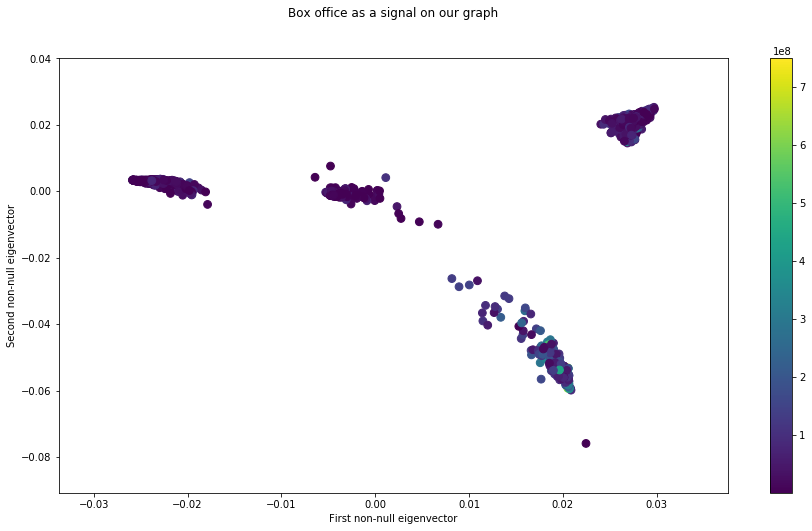

In [9]:
plt.figure(figsize = (15,8))
nodes = nx.draw_networkx_nodes(G, coords, node_size=60, node_color=label_boxoffice)
#nx.draw_networkx_edges(G, coords, alpha=0.1)
plt.title("Box office as a signal on our graph", y=1.08)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)
plt.show()

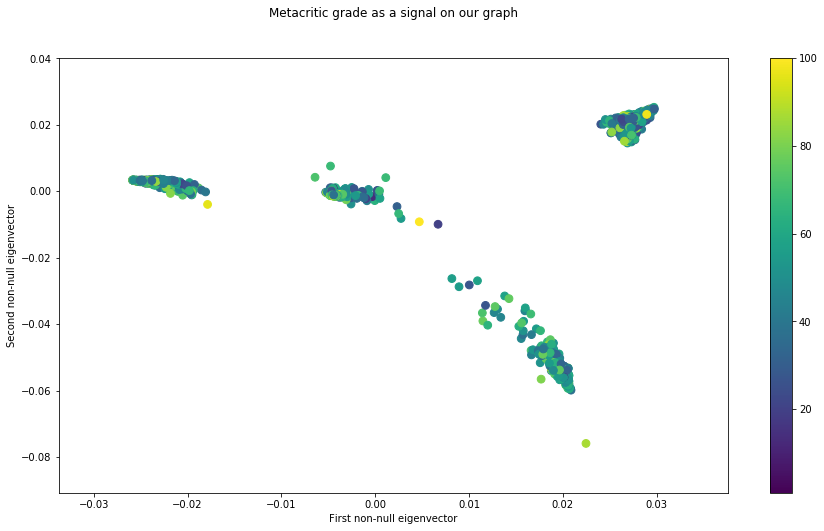

In [10]:
plt.figure(figsize = (15,8))
nodes = nx.draw_networkx_nodes(G, coords, node_size=60, node_color=label_metacritic)
#nx.draw_networkx_edges(G, coords, alpha=0.1)
plt.title("Metacritic grade as a signal on our graph", y=1.08)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)
plt.show()

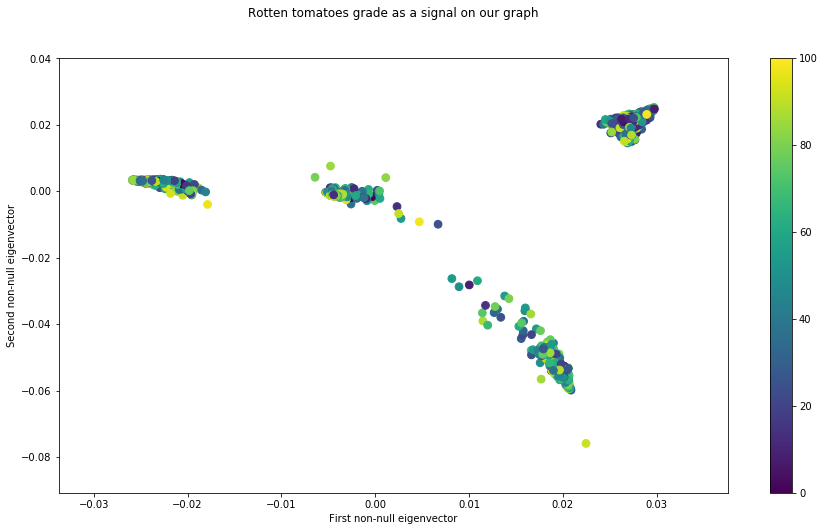

In [11]:
plt.figure(figsize = (15,8))
nodes = nx.draw_networkx_nodes(G, coords, node_size=60, node_color=label_tomato)
#nx.draw_networkx_edges(G, coords, alpha=0.1)
plt.title("Rotten tomatoes grade as a signal on our graph", y=1.08)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)

plt.show()

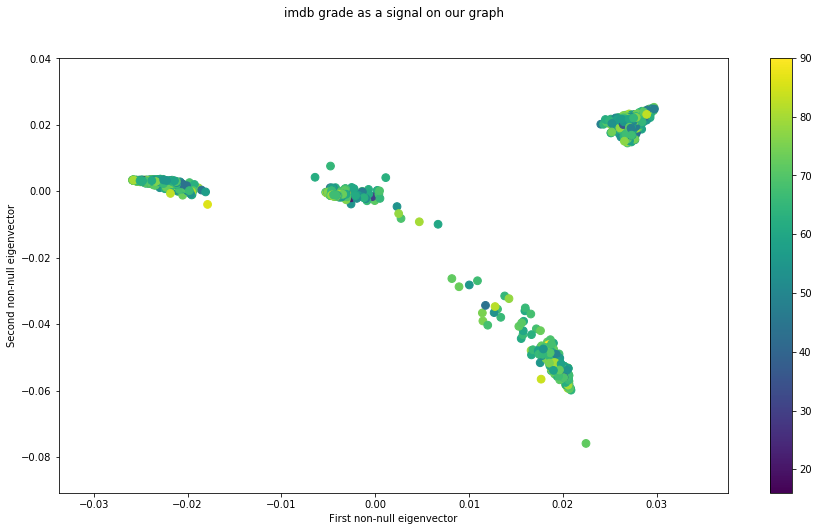

In [12]:
plt.figure(figsize = (15,8))
nodes = nx.draw_networkx_nodes(G, coords, node_size=60, node_color=label_imdb)
#nx.draw_networkx_edges(G, coords, alpha=0.1)
plt.title("imdb grade as a signal on our graph", y=1.08)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)

plt.show()

## C. Clustering

We used DBSCAN

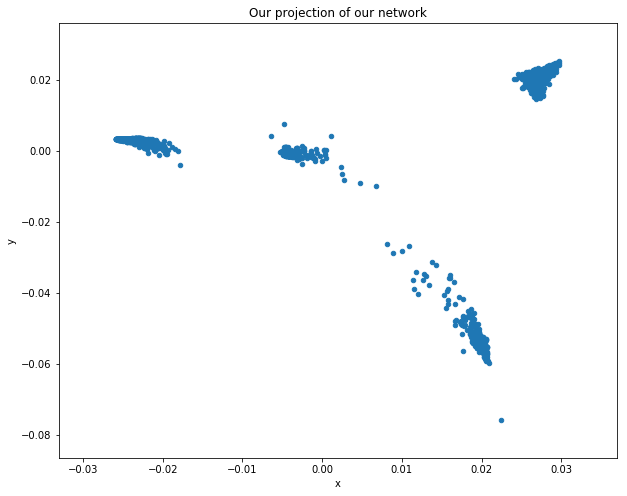

In [13]:
projection_df = pd.DataFrame({'x':coords[:, 0], 'y':coords[:,1]})

projection_df.plot(x = 'x', y = 'y', kind='scatter', figsize=(10, 8), title='Our projection of our network')
plt.show()

In [14]:
def cluster(df, eps=0.3, min_samples=10):
    """Compute and display clusters
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the needed information.
    eps: float
        Distance to consider for neighbors for the DBSCAN algorithm.
    min_samples: int
        Minimum number of points to consider the set of points as a cluster and no outliers.
    
    Returns:
    ---------
    labels: numpy.ndarray
        The labels associated with each point.
    """
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    if n_clusters_ > 0:
        if len(list(set(labels))) > 1:
            print("Silhouette Coefficient: %0.3f"
                  % metrics.silhouette_score(X, labels))
        else:
            print("Silhouette Coefficient could not be computed for 1 cluster and 0 noise points")
    else:
        print("Silhouette Coefficient could not be computed for 0 clusters")

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    plt.figure(figsize=(10,7))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

Estimated number of clusters: 4
Estimated number of noise points: 1
Silhouette Coefficient: 0.901


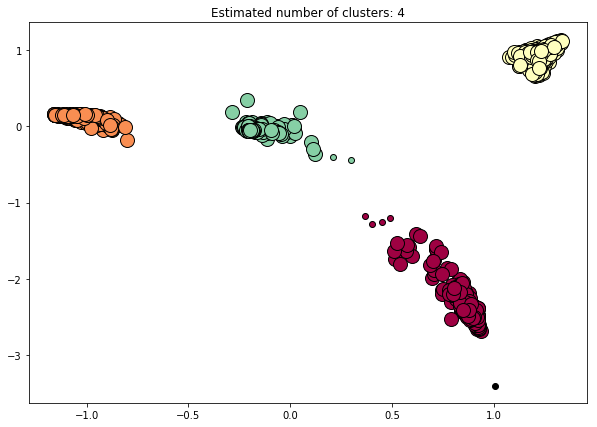

In [15]:
labels = cluster(projection_df, eps=0.35, min_samples=10)

We have 4 distinct clusters. The silhouette coefficient is 0.901 which means the cluster qualities are high (maximum is 1). 

In [16]:
cluster1 = list(np.argwhere(labels==0).flatten())
cluster2 = list(np.argwhere(labels==1).flatten())
cluster3 = list(np.argwhere(labels==2).flatten())
cluster4 = list(np.argwhere(labels==3).flatten())

In [17]:
print('Range of budgets for cluster 1:', set(final_df.loc[cluster1].Budget))
print('Range of budgets for cluster 2:', set(final_df.loc[cluster2].Budget))
print('Range of budgets for cluster 3:', set(final_df.loc[cluster3].Budget))
print('Range of budgets for cluster 4:', set(final_df.loc[cluster4].Budget))

Range of budgets for cluster 1: {5}
Range of budgets for cluster 2: {3}
Range of budgets for cluster 3: {4}
Range of budgets for cluster 4: {1, 2}


In [18]:
print('Mean box office for cluster 1 in million $ (high budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster1].BoxOffice.values)/10**6))
print('Mean box office for cluster 3 in million $ (medium budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster2].BoxOffice.values)/10**6))
print('Mean box office for cluster 2 in million $ (low budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster3].BoxOffice.values)/10**6))
print('Mean box office for cluster 4 in million $ (independent): {d:.3f}'.format(d=np.mean(final_df.loc[cluster4].BoxOffice.values)/10**6))

Mean box office for cluster 1 in million $ (high budget): 167.204
Mean box office for cluster 3 in million $ (medium budget): 33.203
Mean box office for cluster 2 in million $ (low budget): 72.064
Mean box office for cluster 4 in million $ (independent): 13.280


In [19]:
print('Mean Rotten Tomatoes grade for cluster 1 (high budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster1].tomatoGrade.values)))
print('Mean Rotten Tomatoes grade for cluster 3 (medium budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster2].tomatoGrade.values)))
print('Mean Rotten Tomatoes grade for cluster 2 (low budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster3].tomatoGrade.values)))
print('Mean Rotten Tomatoes grade for cluster 4 (independent): {d:.3f}'.format(d=np.mean(final_df.loc[cluster4].tomatoGrade.values)))

Mean Rotten Tomatoes grade for cluster 1 (high budget): 58.841
Mean Rotten Tomatoes grade for cluster 3 (medium budget): 51.152
Mean Rotten Tomatoes grade for cluster 2 (low budget): 46.645
Mean Rotten Tomatoes grade for cluster 4 (independent): 65.920


In [20]:
print('Mean Metacritics grade for cluster 1 (high budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster1].metacriticGrade.values)))
print('Mean Metacritics grade for cluster 3 (medium budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster2].metacriticGrade.values)))
print('Mean Metacritics grade for cluster 2 (low budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster3].metacriticGrade.values)))
print('Mean Metacritics grade for cluster 4 (independent): {d:.3f}'.format(d=np.mean(final_df.loc[cluster4].metacriticGrade.values)))

Mean Metacritics grade for cluster 1 (high budget): 57.504
Mean Metacritics grade for cluster 3 (medium budget): 52.429
Mean Metacritics grade for cluster 2 (low budget): 50.520
Mean Metacritics grade for cluster 4 (independent): 60.950


In [21]:
print('Mean imdb grade for cluster 1 (high budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster1].imdbGrade.values)))
print('Mean imdb grade for cluster 3 (medium budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster2].imdbGrade.values)))
print('Mean imdb grade for cluster 2 (low budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster3].imdbGrade.values)))
print('Mean imdb grade for cluster 4 (independent): {d:.3f}'.format(d=np.mean(final_df.loc[cluster4].imdbGrade.values)))

Mean imdb grade for cluster 1 (high budget): 67.215
Mean imdb grade for cluster 3 (medium budget): 63.697
Mean imdb grade for cluster 2 (low budget): 63.447
Mean imdb grade for cluster 4 (independent): 66.650


In [22]:
def flatten_set(set_array):
    flattened = []
    for i in range(len(set_array)):
        flattened = flattened + list(set_array[i])
    
    return set(flattened)

In [23]:
print('Directors per film in cluster 1 (high budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster1].Director.values))/len(final_df.loc[cluster1])))
print('Directors per film in cluster 3 (medium budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster3].Director.values))/len(final_df.loc[cluster3])))
print('Directors per film in cluster 2 (low budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster2].Director.values))/len(final_df.loc[cluster2])))
print('Directors per film in cluster 4 (independent): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster4].Director.values))/len(final_df.loc[cluster4])))

Directors per film in cluster 1 (high budget): 0.693
Directors per film in cluster 3 (medium budget): 0.716
Directors per film in cluster 2 (low budget): 0.804
Directors per film in cluster 4 (independent): 0.991


In [24]:
print('Actors per film in cluster 1 (high budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster1].Actors.values))/len(final_df.loc[cluster1])))
print('Actors per film in cluster 3 (medium budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster3].Actors.values))/len(final_df.loc[cluster3])))
print('Actors per film in cluster 2 (low budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster2].Actors.values))/len(final_df.loc[cluster2])))
print('Actors per film in cluster 4 (independent): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster4].Actors.values))/len(final_df.loc[cluster4])))

Actors per film in cluster 1 (high budget): 2.504
Actors per film in cluster 3 (medium budget): 2.369
Actors per film in cluster 2 (low budget): 2.597
Actors per film in cluster 4 (independent): 3.558


In [25]:
print('Writers per film in cluster 1 (high budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster1].Writer.values))/len(final_df.loc[cluster1])))
print('Writers per film in cluster 3 (medium budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster3].Writer.values))/len(final_df.loc[cluster3])))
print('Writers per film in cluster 2 (low budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster2].Writer.values))/len(final_df.loc[cluster2])))
print('Writers per film in cluster 4 (independent): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster4].Writer.values))/len(final_df.loc[cluster4])))

Writers per film in cluster 1 (high budget): 2.230
Writers per film in cluster 3 (medium budget): 2.069
Writers per film in cluster 2 (low budget): 1.828
Writers per film in cluster 4 (independent): 1.724


In [26]:
print('Genres per film in cluster 1 (high budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster1].Genre.values))/len(final_df.loc[cluster1])))
print('Genres per film in cluster 3 (medium budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster3].Genre.values))/len(final_df.loc[cluster3])))
print('Genres per film in cluster 2 (low budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster2].Genre.values))/len(final_df.loc[cluster2])))
print('Genres per film in cluster 4 (independent): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster4].Genre.values))/len(final_df.loc[cluster4])))

Genres per film in cluster 1 (high budget): 0.074
Genres per film in cluster 3 (medium budget): 0.036
Genres per film in cluster 2 (low budget): 0.027
Genres per film in cluster 4 (independent): 0.062


In [27]:
print('Production companies per film in cluster 1 (high budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster1].Production.values))/len(final_df.loc[cluster1])))
print('Production companies per film in cluster 3 (medium budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster3].Production.values))/len(final_df.loc[cluster3])))
print('Production companies per film in cluster 2 (low budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster2].Production.values))/len(final_df.loc[cluster2])))
print('Production companies per film in cluster 4 (independent): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster4].Production.values))/len(final_df.loc[cluster4])))

Production companies per film in cluster 1 (high budget): 0.093
Production companies per film in cluster 3 (medium budget): 0.080
Production companies per film in cluster 2 (low budget): 0.124
Production companies per film in cluster 4 (independent): 0.270


In [28]:
print('Rated categories per film in cluster 1 (high budget):', flatten_set(final_df.loc[cluster1].Rated.values))
print('Rated categories per film in cluster 3 (medium budget):', flatten_set(final_df.loc[cluster3].Rated.values))
print('Rated categories per film in cluster 2 (low budget):', flatten_set(final_df.loc[cluster2].Rated.values))
print('Rated categories per film in cluster 4 (independent):', flatten_set(final_df.loc[cluster4].Rated.values))

Rated categories per film in cluster 1 (high budget): {'R', 'G', 'PG', 'PG-13'}
Rated categories per film in cluster 3 (medium budget): {'UNRATED', 'PG', 'R', 'G', 'PG-13'}
Rated categories per film in cluster 2 (low budget): {'UNRATED', 'PG', 'R', 'G', 'PG-13'}
Rated categories per film in cluster 4 (independent): {'UNRATED', 'PG', 'NC-17', 'R', 'G', 'PG-13'}


In [29]:
final_df.columns

Index(['Actors', 'BoxOffice', 'Director', 'Genre', 'metacriticGrade', 'Plot',
       'Production', 'Rated', 'Title', 'Writer', 'imdbGrade', 'tomatoGrade',
       'Wins', 'Nominations', 'Budget'],
      dtype='object')

In [30]:
print('Mean Wins for cluster 1 (high budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster1].Wins.values)))
print('Mean Wins for cluster 3 (medium budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster2].Wins.values)))
print('Mean Wins for cluster 2 (low budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster3].Wins.values)))
print('Mean Wins for cluster 4 (independent): {d:.3f}'.format(d=np.mean(final_df.loc[cluster4].Wins.values)))

Mean Wins for cluster 1 (high budget): 14.807
Mean Wins for cluster 3 (medium budget): 8.206
Mean Wins for cluster 2 (low budget): 6.974
Mean Wins for cluster 4 (independent): 11.395


In [31]:
print('Mean Nominations for cluster 1 (high budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster1].Nominations.values)))
print('Mean Nominations for cluster 3 (medium budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster2].Nominations.values)))
print('Mean Nominations for cluster 2 (low budget): {d:.3f}'.format(d=np.mean(final_df.loc[cluster3].Nominations.values)))
print('Mean Nominations for cluster 4 (independent): {d:.3f}'.format(d=np.mean(final_df.loc[cluster4].Nominations.values)))

Mean Nominations for cluster 1 (high budget): 35.633
Mean Nominations for cluster 3 (medium budget): 17.576
Mean Nominations for cluster 2 (low budget): 16.087
Mean Nominations for cluster 4 (independent): 18.395


In [32]:
print('Plot words per film in cluster 1 (high budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster1].Plot.values))/len(final_df.loc[cluster1])))
print('Plot words per film in cluster 3 (medium budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster3].Plot.values))/len(final_df.loc[cluster3])))
print('Plot words per film in cluster 2 (low budget): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster2].Plot.values))/len(final_df.loc[cluster2])))
print('Plot words per film in cluster 4 (independent): {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster4].Plot.values))/len(final_df.loc[cluster4])))

Plot words per film in cluster 1 (high budget): 3.567
Plot words per film in cluster 3 (medium budget): 3.106
Plot words per film in cluster 2 (low budget): 2.583
Plot words per film in cluster 4 (independent): 3.570


In [33]:
def flatten_list(set_array):
    flattened = []
    for i in range(len(set_array)):
        flattened = flattened + list(set_array[i])
    
    return flattened

In [62]:
plot1 = flatten_list(final_df.loc[cluster1].Plot.values)
plot1_df = pd.DataFrame(plot1)
print('Most frequent words in cluster 1 films (high budget)')
plot1_df[0].value_counts()[plot1_df[0].value_counts() >= 10]

Most frequent words in cluster 1 films (high budget)


world      38
life       18
home       15
time       13
team       13
friends    12
war        11
race       11
help       11
son        10
man        10
Name: 0, dtype: int64

In [63]:
plot3 = flatten_list(final_df.loc[cluster3].Plot.values)
plot3_df = pd.DataFrame(plot3)
print('Most frequent words in cluster 3 films (medium budget)')
plot3_df[0].value_counts()[plot3_df[0].value_counts() >= 10]

Most frequent words in cluster 3 films (medium budget)


life         47
man          44
world        42
woman        34
family       32
team         30
love         26
father       25
group        25
wife         24
story        23
order        21
way          21
son          21
home         21
agent        20
daughter     18
town         17
girl         16
friends      16
house        15
mission      14
murder       14
boy          13
friend       13
battle       13
death        13
war          13
help         12
lives        12
years        12
city         12
police       12
school       11
series       11
forces       11
attempt      11
search       10
kids         10
quest        10
couple       10
adventure    10
mother       10
Name: 0, dtype: int64

In [64]:
plot2 = flatten_list(final_df.loc[cluster2].Plot.values)
plot2_df = pd.DataFrame(plot2)
print('Most frequent words in cluster 2 films (low budget)')
plot2_df[0].value_counts()[plot2_df[0].value_counts() >= 10]

Most frequent words in cluster 2 films (low budget)


life            75
man             67
woman           64
family          58
school          50
story           45
friends         43
girl            38
love            35
years           35
world           35
group           32
order           32
wife            30
father          29
son             29
couple          28
relationship    28
friend          27
lives           26
town            25
home            24
boy             23
people          23
day             22
mother          20
parents         20
husband         20
way             20
college         19
                ..
men             14
murder          14
star            14
officer         14
drama           14
country         13
night           13
children        13
series          12
sister          12
help            12
drug            12
police          12
pair            11
accident        11
war             11
child           11
death           11
boyfriend       11
truth           10
past            10
forces      

In [60]:
plot4 = flatten_list(final_df.loc[cluster4].Plot.values)
plot4_df = pd.DataFrame(plot4)
print('Most frequent words in cluster 4 films (independent)')
plot4_df[0].value_counts()[plot4_df[0].value_counts() >= 5]

Most frequent words in cluster 4 films (independent)


family           39
life             38
woman            32
man              26
story            19
mother           19
friends          17
group            16
world            16
love             16
girl             15
years            14
home             14
son              13
school           13
relationship     12
college          11
friend           11
father           11
time             11
child            10
daughter         10
murder            9
death             9
couple            9
crime             9
town              8
days              8
film              8
lives             8
                 ..
women             8
series            7
team              7
brother           7
friendship        7
revenge           7
party             7
wife              7
dealer            6
events            6
year              6
struggle          6
teenager          6
killer            6
sex               6
forces            6
police            6
summer            5
prison            5


In [70]:
test = np.log10(final_df.BoxOffice.values)

In [66]:
test

array([20.43518368, 19.55015892, 19.15678076, ..., 12.90500556,
        9.17045544, 12.88008797])

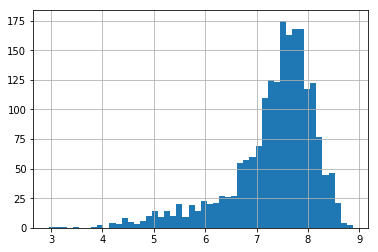

In [71]:
test_df = pd.DataFrame(test)
test_df[0].hist(bins=50)

In [68]:
final_df.BoxOffice.values

array([749700000, 309404152, 208777731, ...,    402321,      9609,
          392420])